# Imports and Installs

In [2]:
#%pip install git+https://github.com/TattaBio/DGEB.git
#%pip install gffutils
#%pip install shap

In [3]:
#import dgeb stuff
from dgeb.tasks import EcoliOperon, PairClassificationEvaluator
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

#import basic stuff/tools
import pandas as pd
import numpy as np
import re
import os
import gzip
import matplotlib.pyplot as plt
import shap

#import Bio stuff
from Bio import SeqIO, motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

#import sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    precision_recall_curve
)

# Data

## Importing dataset from DGEB

In [6]:
#help(EcoliOperon.metadata)
#print(EcoliOperon.metadata)
task = EcoliOperon()
hf_ds = load_dataset(task.metadata.datasets[0].path)
df = pd.DataFrame(hf_ds["train"])
display(df.head())

,Entry,Sequence,Label
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,1
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,0
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0


## Extracting biologically motivated features

### making a pairs df (for convenience, also more intuitive) 

In [9]:
def extract_protein_id(entry):
    """Extracts the protein identifier from the Entry string."""
    match = re.search(r"U00096\.3_prot_([A-Z0-9]+\.\d+)", entry)
    if match:
        return match.group(1)
    else:
        return None

def create_pairs(df):
    """Creates pairs of consecutive proteins from the DataFrame."""
    pairs = []
    for i in range(len(df) - 1):
        protein_A = df.iloc[i]
        protein_B = df.iloc[i + 1]
        pairs.append({
            "Entry_A": protein_A["Entry"],
            "Sequence_A": protein_A["Sequence"],
            "Entry_B": protein_B["Entry"],
            "Sequence_B": protein_B["Sequence"],
            "Label": protein_A["Label"]
        })
    return pd.DataFrame(pairs)

In [10]:
# Extract protein IDs
df['protein_id'] = df['Entry'].apply(extract_protein_id)
df = df.dropna(subset=['protein_id'])

# Create protein pairs
pairs_df = create_pairs(df.copy()) # Pass a copy to avoid modifying original df

pairs_df['refseq_A'] = pairs_df['Entry_A'].apply(extract_protein_id)
pairs_df['refseq_B'] = pairs_df['Entry_B'].apply(extract_protein_id)

# Display the result
print("\nPairs DataFrame:")
display(pairs_df.head())


Pairs DataFrame:


,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,refseq_A,refseq_B
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,AAC73112.1,AAC73113.1
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,AAC73113.1,AAC73114.1
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,AAC73114.1,AAC73115.1
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,AAC73115.1,AAC73116.1
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,0,AAC73116.1,AAC73117.1


### GC-content

In [12]:
def load_genbank_annotations(gbff_file):
    """Parse GenBank file to extract gene annotations for coding sequences."""
    gene_annotations = {}
    for record in SeqIO.parse(gbff_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS" and "protein_id" in feature.qualifiers:
                pid = feature.qualifiers["protein_id"][0]
                loc = feature.location
                gene_annotations[pid] = {
                    "start": int(loc.start),
                    "end":   int(loc.end),
                    "strand": int(loc.strand)
                }
    return gene_annotations

# 1) Annotations
with gzip.open("data/GCF_000005845.2_ASM584v2_genomic.gbff.gz", "rt") as handle:
    gene_annotations = load_genbank_annotations(handle)

print("Sample Gene Annotations:", list(gene_annotations.items())[:5])
print("-" * 40)

# 2) Genome FASTA
with open("data/GCF_000005845.2_ASM584v2_genomic.fna", "rt") as fasta:
    genome_record = SeqIO.read(fasta, "fasta")

# 3) DNA GC‐content calculator
def calculate_gc_content_dna(seq: str) -> float:
    s = seq.upper()
    return (s.count("G") + s.count("C")) / len(s) if seq else 0.0

# 4) Compute per‐gene GC
dna_gc = {}
for pid, ann in gene_annotations.items():
    seq = genome_record.seq[ann["start"]:ann["end"]]
    if ann["strand"] == -1:
        seq = seq.reverse_complement()
    dna_gc[pid] = calculate_gc_content_dna(str(seq))

print("Sample dna_gc values:", list(dna_gc.items())[:5])
print("-" * 40)

# --- Load protein sequences from the FASTA file ---
def load_protein_sequences(fasta_file):
    """Load protein sequences from a FASTA file."""
    protein_sequences = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        protein_id = record.id
        sequence = str(record.seq)
        protein_sequences[protein_id] = sequence
    return protein_sequences

protein_fasta_file_path = gzip.open('data/GCF_000005845.2_ASM584v2_protein.faa.gz', 'rt')
protein_sequences = load_protein_sequences(protein_fasta_file_path)

#Map onto pairs_df
# Build a quick Sequence → NP_id lookup from your protein FASTA
seq_to_pid = { seq: pid for pid, seq in protein_sequences.items() }

# Now add the NP_… IDs into pairs_df
pairs_df['refseq_A'] = pairs_df['Sequence_A'].map(seq_to_pid)
pairs_df['refseq_B'] = pairs_df['Sequence_B'].map(seq_to_pid)

# And _then_ map your dna_gc over those
pairs_df['gc_content_A']         = pairs_df['refseq_A'].map(dna_gc)
pairs_df['gc_content_B']         = pairs_df['refseq_B'].map(dna_gc)
pairs_df['gc_content_difference'] = (
    abs(pairs_df['gc_content_A'] - pairs_df['gc_content_B'])
)
# Quick sanity check
display(pairs_df.head())

Sample Gene Annotations: [('NP_414542.1', {'start': 189, 'end': 255, 'strand': 1}), ('NP_414543.1', {'start': 336, 'end': 2799, 'strand': 1}), ('NP_414544.1', {'start': 2800, 'end': 3733, 'strand': 1}), ('NP_414545.1', {'start': 3733, 'end': 5020, 'strand': 1}), ('NP_414546.1', {'start': 5233, 'end': 5530, 'strand': 1})]
----------------------------------------
Sample dna_gc values: [('NP_414542.1', 0.5151515151515151), ('NP_414543.1', 0.5306536743808363), ('NP_414544.1', 0.5627009646302251), ('NP_414545.1', 0.5283605283605284), ('NP_414546.1', 0.5387205387205387)]
----------------------------------------


,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,refseq_A,refseq_B,gc_content_A,gc_content_B,gc_content_difference
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,NP_414542.1,NP_414543.1,0.515152,0.530654,0.015502
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,NP_414543.1,NP_414544.1,0.530654,0.562701,0.032047
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,NP_414544.1,NP_414545.1,0.562701,0.528361,0.034340
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,NP_414545.1,NP_414546.1,0.528361,0.538721,0.010360
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,0,NP_414546.1,NaN,0.538721,NaN,NaN


In [13]:
pairs_df.isnull().sum()

Entry_A                  0
Sequence_A               0
Entry_B                  0
Sequence_B               0
Label                    0
refseq_A                 1
refseq_B                 1
gc_content_A             1
gc_content_B             1
gc_content_difference    2
dtype: int64

In [14]:
# Show rows where refseq_A or refseq_B is missing
missing_rows = pairs_df[pairs_df['refseq_A'].isnull() | pairs_df['refseq_B'].isnull()]
display(missing_rows)

,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,refseq_A,refseq_B,gc_content_A,gc_content_B,gc_content_difference
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,0,NP_414546.1,NaN,0.538721,NaN,NaN
5,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,U00096.3_prot_AAC73118.1_7,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...,0,NaN,NP_414548.1,NaN,0.533194,NaN


In [15]:
# Check if the problematic protein_id is in your annotations
'AAC73118.1_6' in gene_annotations  # Should return False

False

In [16]:
pairs_df.shape

(4297, 10)

In [17]:
# Drop rows where either refseq_A or refseq_B is missing
pairs_df = pairs_df.dropna(subset=['refseq_A', 'refseq_B']).reset_index(drop=True)

# Confirm the shape afterward
print(f"Remaining rows after dropping: {pairs_df.shape[0]}")

Remaining rows after dropping: 4295


### Strand concordance, Orientation, Intergenic Distance, Overlap

In [19]:
def extract_features_from_annotations(pairs_df, gene_annotations):
    """
    Core feature extraction WITHOUT motif scanning.
    Produces:
    - Strand concordance
    - Orientation patterns (one-hot)
    - Intergenic distance
    - Overlap features
    """
    # Initialize feature storage
    features = {
        'strand_concordant': [],
        'intergenic_distance': [],
        'genes_overlap': [],
        'overlap_length': [],
        'orientation_++': [],
        'orientation_--': [],
        'orientation_+-': [],
        'orientation_-+': [],
    }

    for _, row in pairs_df.iterrows():
        ann_a = gene_annotations.get(row['refseq_A'])
        ann_b = gene_annotations.get(row['refseq_B'])

        if not (ann_a and ann_b):
            # Handle missing annotations
            for key in features:
                features[key].append(None)
            continue

        # 1. Strand concordance
        same_strand = int(ann_a['strand'] == ann_b['strand'])
        features['strand_concordant'].append(same_strand)

        # 2. Orientation patterns (one-hot encoded)
        strand_a = '+' if ann_a['strand'] == 1 else '-'
        strand_b = '+' if ann_b['strand'] == 1 else '-'
        orientation = f"{strand_a}{strand_b}"
        
        features['orientation_++'].append(int(orientation == '++'))
        features['orientation_--'].append(int(orientation == '--'))
        features['orientation_+-'].append(int(orientation == '+-'))
        features['orientation_-+'].append(int(orientation == '-+'))

        # 3. Distance calculation
        if ann_a['strand'] == 1:
            distance = ann_b['start'] - ann_a['end']
            overlap = int(ann_a['end'] > ann_b['start'])
        else:
            distance = ann_a['start'] - ann_b['end']
            overlap = int(ann_b['end'] > ann_a['start'])

        features['intergenic_distance'].append(abs(distance))
        features['genes_overlap'].append(overlap)
        features['overlap_length'].append(abs(distance) if overlap else 0)

    # Add features to DataFrame
    for feature_name, values in features.items():
        pairs_df[feature_name] = values

    return pairs_df

In [20]:
pairs_df = extract_features_from_annotations(pairs_df, gene_annotations)
pairs_df

,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,refseq_A,refseq_B,gc_content_A,gc_content_B,gc_content_difference,strand_concordant,intergenic_distance,genes_overlap,overlap_length,orientation_++,orientation_--,orientation_+-,orientation_-+
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,NP_414542.1,NP_414543.1,0.515152,0.530654,0.015502,1,81,0,0,1,0,0,0
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,NP_414543.1,NP_414544.1,0.530654,0.562701,0.032047,1,1,0,0,1,0,0,0
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,NP_414544.1,NP_414545.1,0.562701,0.528361,0.034340,1,0,0,0,1,0,0,0
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,NP_414545.1,NP_414546.1,0.528361,0.538721,0.010360,1,213,0,0,1,0,0,0
4,U00096.3_prot_AAC73118.1_7,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...,U00096.3_prot_AAC73119.1_8,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,0,NP_414548.1,NP_414549.1,0.533194,0.519916,0.013277,0,2663,1,2663,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4290,U00096.3_prot_AAC77352.1_4310,MRIGMRLLLGYFLLVAVAAWFVLAIFVKEVKPGVRRATEGTLIDTA...,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,1,NP_418816.1,NP_418817.1,0.538947,0.495935,0.043012,1,57,0,0,1,0,0,0
4291,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,0,NP_418817.1,NP_418818.1,0.495935,0.510460,0.014525,0,59,0,0,0,0,1,0
4292,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,0,NP_418818.1,NP_418819.1,0.510460,0.425532,0.084928,0,953,1,953,0,0,0,1
4293,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,U00096.3_prot_UMR55121.1_4314,MSRFIFYKIILSKQKDM,0,NP_418819.1,YP_010283921.1,0.425532,0.240741,0.184791,1,175,0,0,1,0,0,0


### Functional/Category Match (shared COG)

In [22]:
# Load eggnog data (your existing working version)
eggnog_file = 'data/MM_4125ylpq.emapper.annotations.tsv'
eggnog_df = pd.read_csv(eggnog_file, sep='\t', skiprows=4)
eggnog_df = eggnog_df[~eggnog_df['#query'].astype(str).str.startswith('##')]

# Create COG mapping dictionary
cog_map = (
    eggnog_df.assign(protein_id=lambda x: x['#query'].str.split('.').str[0])
    .set_index('protein_id')['COG_category']
    .to_dict()
)

# Add COG features to pairs dataframe
def add_cog_features(pairs_df):
    """Add COG match features using your existing eggnog dataframe"""
    # Extract base protein IDs (no version numbers)
    pairs_df['protein_id_A'] = pairs_df['refseq_A'].str.split('.').str[0]
    pairs_df['protein_id_B'] = pairs_df['refseq_B'].str.split('.').str[0]
    
    # Map COG categories
    pairs_df['COG_A'] = pairs_df['protein_id_A'].map(cog_map)
    pairs_df['COG_B'] = pairs_df['protein_id_B'].map(cog_map)
    
    # Create features
    pairs_df['COG_match'] = (pairs_df['COG_A'] == pairs_df['COG_B']).astype(int)
    pairs_df['COG_similar'] = (
        (pairs_df['COG_A'].str[0] == pairs_df['COG_B'].str[0])
        .fillna(0)
        .astype(int)
    )
    
    # Cleanup temporary columns
    pairs_df.drop(['protein_id_A', 'protein_id_B'], axis=1, inplace=True)
    
    return pairs_df

# Apply to your dataframe
pairs_df = add_cog_features(pairs_df)

# Show results
print("COG features added successfully!")
print("\nSample data with new features:")
display(pairs_df[['refseq_A', 'refseq_B', 'COG_match', 'COG_similar']].head())
pairs_df[['COG_match', 'COG_similar']].value_counts()


with open("data/intergenic_regions.fasta", "w") as out:
    for _, row in pairs_df.iterrows():
        a = row["refseq_A"]
        b = row["refseq_B"]
        annA = gene_annotations.get(a)
        annB = gene_annotations.get(b)
        # skip if either is missing or on different strands
        if annA is None or annB is None or annA["strand"] != annB["strand"]:
            continue

        sA, eA, stA = annA["start"], annA["end"], annA["strand"]
        sB, eB, stB = annB["start"], annB["end"], annB["strand"]

        if stA == 1:
            inter = genome_record.seq[eA : sB]
        else:
            inter = genome_record.seq[eB : sA].reverse_complement()

        inter = inter.upper()
        if len(inter) > 0:
            out.write(f">{a}_{b}|len={len(inter)}\n{inter}\n")

COG features added successfully!

Sample data with new features:


,refseq_A,refseq_B,COG_match,COG_similar
0,NP_414542.1,NP_414543.1,0,0
1,NP_414543.1,NP_414544.1,0,0
2,NP_414544.1,NP_414545.1,0,0
3,NP_414545.1,NP_414546.1,0,0
4,NP_414548.1,NP_414549.1,0,0


### Promoter/Terminator motifs

In [24]:
# reload TF-RISet, skipping the comment lines as before
tfri = pd.read_csv(
    "data/TF-RISet.tsv",
    sep="\t",
    skiprows=44,        # header starts on line 45
    comment="#",
    engine="python"
)

# drop any rows where the sequence field is missing
seq_col = "10)tfrsSeq"
tfri = tfri.dropna(subset=[seq_col])

out_dir = "data/tfbs_fastas"
os.makedirs(out_dir, exist_ok=True)

for tf, grp in tfri.groupby("4)regulatorName"):
    records = []
    for idx, row in grp.iterrows():
        raw = row[seq_col]
        if not isinstance(raw, str):
            # skip any weird entries
            continue
        seq = raw.upper().replace("U", "T")
        records.append(SeqRecord(seq, id=f"{tf}_{idx}", description=""))
    if records:
        fasta_path = os.path.join(out_dir, f"{tf}.fasta")
        SeqIO.write(records, fasta_path, "fasta")

/opt/anaconda3/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [25]:
# 1) Load FIMO output
fimo = pd.read_csv("data/fimo_regdb_tf/fimo.tsv", sep="\t", comment="#")

# 2) Extract the "pair" key (REFSEQ_A_REFSEQ_B) from sequence_name
fimo["pair"] = fimo["sequence_name"].str.split(pat="|", n=1).str[0]

# 3) Count hits per intergenic pair
hit_counts = (
    fimo
    .groupby("pair")
    .size()
    .rename("regdb_tf_hits")
    .reset_index()
)

# 4) Merge back into your existing pairs_df
pairs_df["pair"] = pairs_df["refseq_A"] + "_" + pairs_df["refseq_B"]
pairs_df = pairs_df.merge(hit_counts, on="pair", how="left")
pairs_df["regdb_tf_hits"] = pairs_df["regdb_tf_hits"].fillna(0).astype(int)

# 5) Add a binary flag
pairs_df["has_regdb_tf_site"] = (pairs_df["regdb_tf_hits"] > 0).astype(int)

# 6) Drop the temporary key
pairs_df.drop(columns=["pair"], inplace=True)

# 7) Inspect
display(pairs_df[["regdb_tf_hits","has_regdb_tf_site"]])

,regdb_tf_hits,has_regdb_tf_site
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
4290,0,0
4291,0,0
4292,0,0
4293,0,0


In [26]:
print(pairs_df["regdb_tf_hits"].nunique())
print(pairs_df["regdb_tf_hits"].value_counts())
print(pairs_df["has_regdb_tf_site"].nunique())
print(pairs_df["has_regdb_tf_site"].value_counts())

3
regdb_tf_hits
0    4272
1      22
2       1
Name: count, dtype: int64
2
has_regdb_tf_site
0    4272
1      23
Name: count, dtype: int64


In [27]:
pairs_df["Label"].value_counts(normalize=True)

Label
0    0.593248
1    0.406752
Name: proportion, dtype: float64

## Elastic-Net Logistic Regression 

In [39]:
# Define which columns are features vs. target
feature_cols = [
    "gc_content_A","gc_content_B","gc_content_difference",
    "intergenic_distance","genes_overlap","overlap_length",
    # orientation is already one‐hot as four separate cols
    "orientation_++","orientation_--","orientation_+-","orientation_-+",
    # COG raw categories
    "COG_A","COG_B",
    # binary flags
    "strand_concordant","COG_match","COG_similar",
    # TF‐motif features
    "regdb_tf_hits","has_regdb_tf_site"
]
target_col = "Label"

# Split off X and y
X = pairs_df[feature_cols]
y = pairs_df[target_col].astype(int)

# Train/test split (if you want a hold‐out test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

#print(X_train.shape)
#print(X_test.shape)

# Build preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), [
        "gc_content_A","gc_content_B","gc_content_difference",
        "intergenic_distance","genes_overlap","overlap_length",
        "regdb_tf_hits"
    ]),
    ("cat", OneHotEncoder(
        drop="first",
        sparse_output=False,
        handle_unknown="ignore"   # <— ignore any new COG categories
    ), ["COG_A","COG_B"]),
    # everything else (0/1 and one-hoted orientation) can pass through:
], remainder="passthrough")

# Fit transform on training data
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
# First‐pass elastic‐net logistic regression

# set up a quick grid (feel free to narrow it down if you already know good params)
param_grid = {
    "C":        [0.1, 1, 10, 100],
    "l1_ratio": [0.1, 0.5, 0.9]
}

# wrap LogisticRegression in a GridSearch to pick the best by AP
base_lr = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    max_iter=5000,
    class_weight="balanced"  # optional, given your ~60/40 split
)

grid = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    cv=5,
    scoring="average_precision",
    n_jobs=-1,
    refit=True
)

# fit on processed training set
grid.fit(X_train_proc, y_train)

best_lr = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Training AP:", grid.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best params: {'C': 0.1, 'l1_ratio': 0.5}
Training AP: 0.8144295899065757


In [42]:
# predicted probabilities on the test set
y_proba_test = best_lr.predict_proba(X_test_proc)[:, 1]

# test AP
ap_test = average_precision_score(y_test, y_proba_test)

#Threshold at 0.5 for binary metrics
y_pred_test = (y_proba_test >= 0.5).astype(int)
f1_test  = f1_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test  = recall_score(y_test, y_pred_test)
acc_test  = accuracy_score(y_test, y_pred_test)

#Report
print(f"Test AP:        {ap_test:.3f}")
print(f"Test F1 (0.5):  {f1_test:.3f}")
print(f"Precision (0.5):{prec_test:.3f}")
print(f"Recall (0.5):   {rec_test:.3f}")
print(f"Accuracy:       {acc_test:.3f}")

Test AP:        0.796
Test F1 (0.5):  0.719
Precision (0.5):0.620
Recall (0.5):   0.857
Accuracy:       0.728


Validation-optimal threshold: 0.507  →  F1 = 0.753

Test set @ tuned threshold:
Test AP:        0.796
Test F1:  0.719
Precision:0.620
Recall:   0.857
Accuracy:       0.728


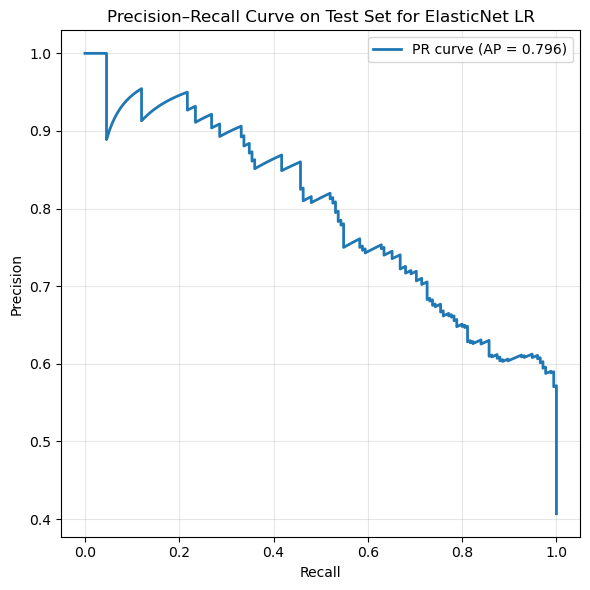

In [43]:
# Get out-of-fold probabilities on TRAINING data
# (uses the same CV as before, but now for predict_proba)
y_train_oof = cross_val_predict(
    best_lr,              # your best_lr from GridSearchCV
    X_train_proc, 
    y_train, 
    cv=5, 
    method="predict_proba",
    n_jobs=-1
)[:,1]

#Find the threshold on TRAIN that maximizes F1
precision, recall, thresholds = precision_recall_curve(y_train, y_train_oof)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx  = np.argmax(f1_scores)
best_thr  = thresholds[best_idx]
best_f1   = f1_scores[best_idx]
print(f"Validation-optimal threshold: {best_thr:.3f}  →  F1 = {best_f1:.3f}")

#Apply that threshold to the TEST set
y_test_proba = best_lr.predict_proba(X_test_proc)[:,1]
y_test_pred  = (y_test_proba >= best_thr).astype(int)

#Compute and report test metrics at this tuned threshold
precision_t = precision_score(y_test, y_test_pred)
recall_t    = recall_score(y_test, y_test_pred)
f1_t        = f1_score(y_test, y_test_pred)
acc_t       = accuracy_score(y_test, y_test_pred)
ap_test     = average_precision_score(y_test, y_test_proba)

#Report
print("\nTest set @ tuned threshold:")
print(f"Test AP:        {ap_test:.3f}")
print(f"Test F1:  {f1_test:.3f}")
print(f"Precision:{prec_test:.3f}")
print(f"Recall:   {rec_test:.3f}")
print(f"Accuracy:       {acc_test:.3f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {ap_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve on Test Set for ElasticNet LR')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('graphs/PR curve', dpi=300, bbox_inches='tight')
plt.show()

,gc_content_difference,intergenic_distance,overlap_length,regdb_tf_hits,genes_overlap
gc_content_difference,1.000000,0.109444,0.097325,0.014865,-0.078077
intergenic_distance,0.109444,1.000000,0.864268,-0.007584,0.027051
overlap_length,0.097325,0.864268,1.000000,-0.006530,0.073080
regdb_tf_hits,0.014865,-0.007584,-0.006530,1.000000,-0.089354
genes_overlap,-0.078077,0.027051,0.073080,-0.089354,1.000000


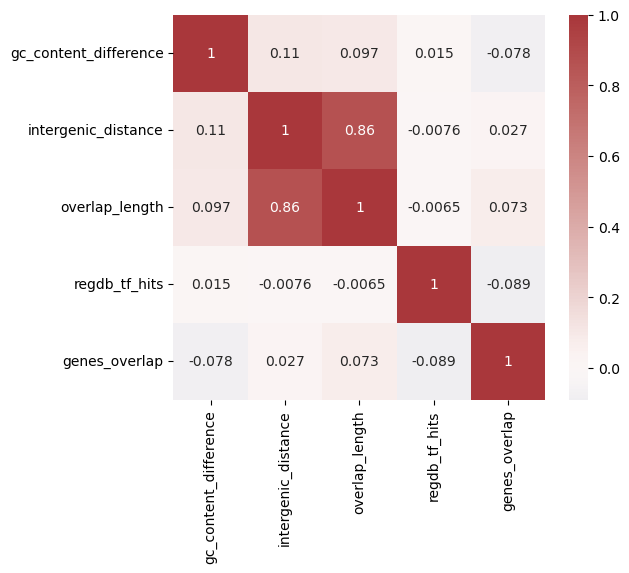

In [44]:
import seaborn as sns
num_cols = ["gc_content_difference","intergenic_distance","overlap_length","regdb_tf_hits","genes_overlap"]
corr = pairs_df[num_cols].corr()
display(corr)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.show()

## SHAP-weighted Elastic-Net Logistic Regression

                         feature  mean_abs_shap
0   remainder__strand_concordant       1.157009
1             num__genes_overlap       0.808970
2      remainder__orientation_++       0.677170
3      remainder__orientation_-+       0.378022
4         remainder__COG_similar       0.282507
5     num__gc_content_difference       0.189329
6                   cat__COG_B_S       0.187675
7      remainder__orientation_+-       0.114103
8           remainder__COG_match       0.111364
9              num__gc_content_A       0.109241
10             num__gc_content_B       0.097064
11                  cat__COG_A_S       0.078574
12           num__overlap_length       0.048755
13     remainder__orientation_--       0.044440
14                  cat__COG_A_K       0.043359
15      num__intergenic_distance       0.040374
16                cat__COG_B_nan       0.038596
17                  cat__COG_A_C       0.033133
18                  cat__COG_B_K       0.023504
19                  cat__COG_A_G       0

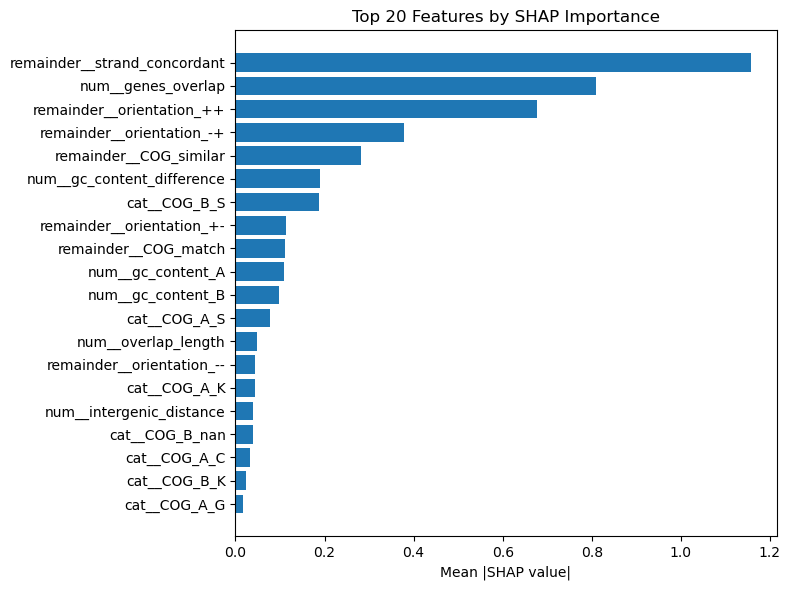

In [46]:
#Compute SHAP values on preprocessed training set
explainer = shap.LinearExplainer(
    best_lr,                # your trained LogisticRegression
    shap.maskers.Independent(data=X_train_proc)
)
shap_vals = explainer.shap_values(X_train_proc)  # shape = (n_samples, n_features)

#DataFrame of mean(|SHAP|) per feature
feature_names = preprocessor.get_feature_names_out()  # list of column names
mean_imp = np.abs(shap_vals).mean(axis=0)

shap_df = pd.DataFrame({
    "feature":        feature_names,
    "mean_abs_shap":  mean_imp
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

#Peek at the top 20
print(shap_df.head(20))

#Plot a bar chart of the top 20
plt.figure(figsize=(8,6))
plt.barh(
    shap_df["feature"].iloc[:20][::-1],
    shap_df["mean_abs_shap"].iloc[:20][::-1]
)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Features by SHAP Importance")
plt.tight_layout()
plt.savefig('graphs/SHAP_bar_plot', dpi=300, bbox_inches='tight')
plt.show()

🔍 Shap-LR best params: {'C': 0.1, 'l1_ratio': 0.9}
🔍 Shap-LR CV Training AP: 0.8140029275628933

Shap-LR on TEST @ 0.5:
  AP:        0.798
  F1:        0.711
  Precision: 0.622
  Recall:    0.829
  Accuracy:  0.726
SHAP‐weighted TRAIN optimal threshold = 0.426 → F1 = 0.753
SHAP‐weighted TEST @ tuned threshold:
  AP:        0.798
  F1:        0.722
  Precision: 0.607
  Recall:    0.891
  Accuracy:  0.721


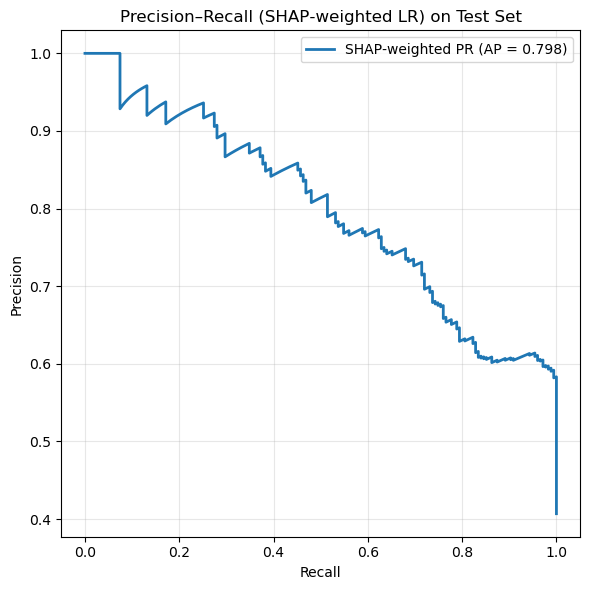

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)

# 1) Compute per-feature C_j from SHAP importances (mean_imp)
base_C   = best_lr.C
imp_norm = (mean_imp - mean_imp.min()) / (mean_imp.max() - mean_imp.min())
lb       = 0.5
C_j_full = base_C * (lb + (1 - lb) * imp_norm)

# 2) Scale X_train_proc and X_test_proc by 1/sqrt(C_j)
X_train_shap = X_train_proc.astype(float).copy()
X_test_shap  = X_test_proc.astype(float).copy()
for j in range(X_train_shap.shape[1]):
    factor = np.sqrt(C_j_full[j])
    X_train_shap[:, j] /= factor
    X_test_shap[:,  j] /= factor

# 3) GridSearchCV on SHAP‐scaled data
param_grid = {
    "C":        [0.1, 1, 10, 100],
    "l1_ratio": [0.1, 0.5, 0.9]
}
base_shap_lr = LogisticRegression(
    penalty="elasticnet", solver="saga",
    max_iter=5000, class_weight="balanced"
)
grid_shap = GridSearchCV(
    base_shap_lr,
    param_grid=param_grid,
    cv=5,
    scoring="average_precision",
    n_jobs=-1,
    refit=True
)
grid_shap.fit(X_train_shap, y_train)

best_shap_lr = grid_shap.best_estimator_
print("🔍 Shap-LR best params:", grid_shap.best_params_)
print("🔍 Shap-LR CV Training AP:", grid_shap.best_score_)

# 4) TEST‐set metrics @ default 0.5 threshold
y_test_proba = best_shap_lr.predict_proba(X_test_shap)[:, 1]
y_test_pred5 = (y_test_proba >= 0.5).astype(int)
print("\nShap-LR on TEST @ 0.5:")
print(f"  AP:        {average_precision_score(y_test, y_test_proba):.3f}")
print(f"  F1:        {f1_score(y_test, y_test_pred5):.3f}")
print(f"  Precision: {precision_score(y_test, y_test_pred5):.3f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred5):.3f}")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred5):.3f}")

# 5) OOF probabilities on TRAIN
y_train_oof_shap = cross_val_predict(
    best_shap_lr,
    X_train_shap,
    y_train,
    cv=5,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# 6) Tune threshold on TRAIN for max F1
prec_tr, rec_tr, thr_tr = precision_recall_curve(y_train, y_train_oof_shap)
f1_tr = 2 * (prec_tr * rec_tr) / (prec_tr + rec_tr + 1e-12)
best_i = np.argmax(f1_tr)
best_thr_shap = thr_tr[best_i]
print(f"SHAP‐weighted TRAIN optimal threshold = {best_thr_shap:.3f} → F1 = {f1_tr[best_i]:.3f}")

# 7) Fit on full TRAIN and evaluate TEST @ tuned threshold
best_shap_lr.fit(X_train_shap, y_train)
y_test_pred_shap = (best_shap_lr.predict_proba(X_test_shap)[:, 1] >= best_thr_shap).astype(int)
print("SHAP‐weighted TEST @ tuned threshold:")
print(f"  AP:        {average_precision_score(y_test, y_test_proba):.3f}")
print(f"  F1:        {f1_score(y_test, y_test_pred_shap):.3f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_shap):.3f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_shap):.3f}")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_shap):.3f}")

# 9) Plot PR curve on TEST
prec_ts, rec_ts, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6,6))
plt.plot(rec_ts, prec_ts, lw=2,
         label=f"SHAP‐weighted PR (AP = {average_precision_score(y_test, y_test_proba):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (SHAP‐weighted LR) on Test Set")
plt.legend(loc="best"); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graphs/PR curve SHAP", dpi=300, bbox_inches="tight")
plt.show()